# Bagging Classifier Demo

This notebook demonstrates the `bagging_classifier` from `rice_ml.supervised_learning.ensemble_methods` on a noisy two-moon dataset from scikit-learn. The goal is to show how bootstrap aggregation reduces variance compared to a single decision tree.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons

from rice_ml.supervised_learning.ensemble_methods import bagging_classifier
from rice_ml.supervised_learning.decision_tree import decision_tree
from rice_ml.supervised_learning.preprocess import train_test_split

sns.set_theme()


## Generate a noisy two-moon dataset

We use `sklearn.datasets.make_moons` to create a non-linearly separable dataset with label noise to make the classification task more challenging.

In [9]:
X, y = make_moons(n_samples=600, noise=0.15, random_state=42)
print(f'Dataset shape: X={X.shape}, y={y.shape}')


Dataset shape: X=(600, 2), y=(600,)


## Visualize the raw data

Two interleaving moons form a classic pattern for testing algorithms that capture non-linear decision boundaries.

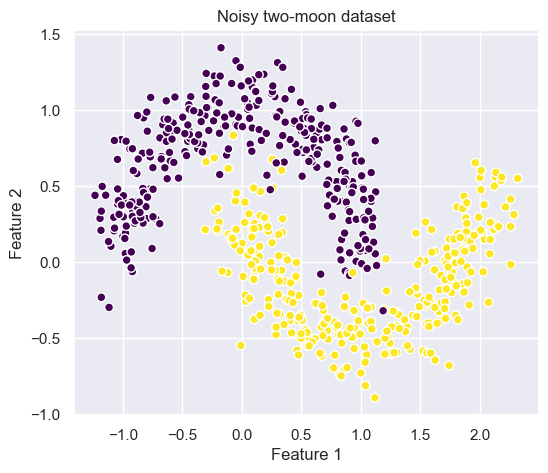

In [10]:
plt.figure(figsize=(6, 5))
palette = sns.color_palette('viridis', n_colors=2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='white', s=40)
plt.title('Noisy two-moon dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


## Split into train and test sets

We use the project's `train_test_split` helper for consistency with other examples.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=0)
print(f'Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}')


Train size: 450, Test size: 150


## Train a single decision tree (baseline)

A single tree can overfit noisy samples. We set a modest depth to highlight its variance on the test set.

In [12]:
single_tree = decision_tree(max_depth=4, random_state=0)
single_tree.fit(X_train, y_train)
tree_train_acc = np.mean(single_tree.predict(X_train) == y_train)
tree_test_acc = np.mean(single_tree.predict(X_test) == y_test)
print(f'Single tree accuracy: train={tree_train_acc:.3f}, test={tree_test_acc:.3f}')


Single tree accuracy: train=0.936, test=0.913


## Train the bagging classifier

We aggregate multiple decision trees trained on bootstrap samples. Averaging their predictions should reduce variance and improve generalization.

In [13]:
bagger = bagging_classifier(
    n_estimators=25,
    max_samples=0.9,
    random_state=0,
    base_params={'max_depth': 4, 'random_state': 0}
)
bagger.fit(X_train, y_train)
bag_train_acc = np.mean(bagger.predict(X_train) == y_train)
bag_test_acc = np.mean(bagger.predict(X_test) == y_test)
print(f'Bagging accuracy: train={bag_train_acc:.3f}, test={bag_test_acc:.3f}')


Bagging accuracy: train=0.964, test=0.927


## Visualize decision boundaries

The plots contrast the decision regions learned by the single tree and the bagging ensemble. The ensemble should produce smoother, more stable boundaries.

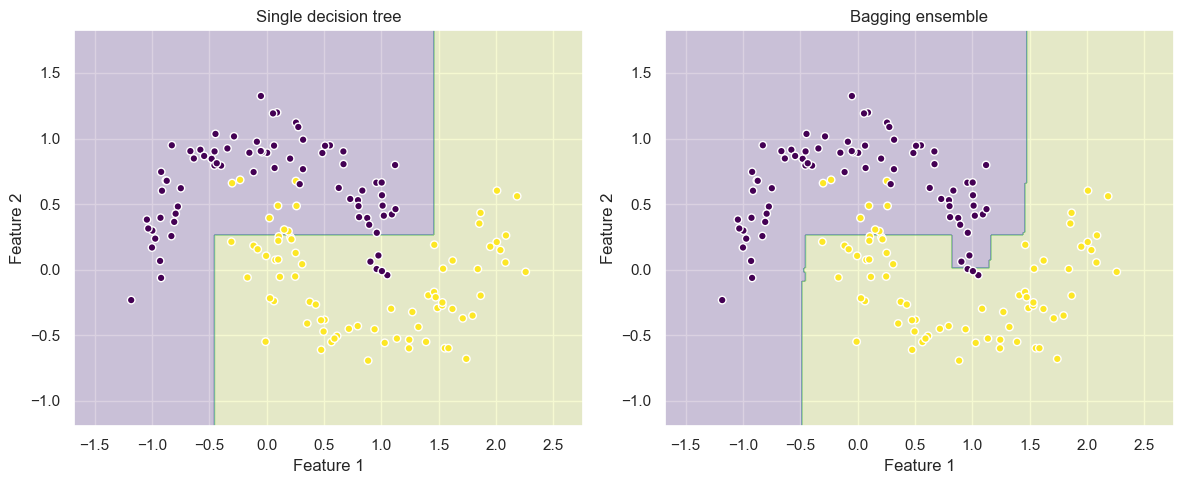

In [14]:
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    preds = model.predict(grid).reshape(xx.shape)
    plt.contourf(xx, yy, preds, alpha=0.2, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='white', s=30)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_decision_boundary(single_tree, X_test, y_test, 'Single decision tree')
plt.subplot(1, 2, 2)
plot_decision_boundary(bagger, X_test, y_test, 'Bagging ensemble')
plt.tight_layout()
plt.show()
